<a href="https://colab.research.google.com/github/codingle2/Data_Analysis_Programming_Class/blob/main/crawling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving stockCodeInfo.xlsx to stockCodeInfo (2).xlsx



1) 거래량 상위 주식 목록
=== 상위 주식 데이터 크롤링 시작 (총 40개 목표) ===
 -> 페이지 1 요청 중...
 -> 페이지 2 요청 중...
                종목명     현재가    등락률          거래량
0  KODEX 200선물인버스2X     678  -3.97  744,006,850
1         엔에이치스팩32호   3,840  92.00   60,567,827
2                동양     881  10.68   54,772,669
3         KODEX 인버스   2,550  -1.92   47,864,617
4  KODEX 코스닥150레버리지  11,975  -3.31   35,284,743

2) KOSPI 정보
┌──────────────────────────────────────────────────┐
│  🇰🇷  [대한민국] 코스피 (코스피) 상세 현황      │
├──────────────────────────────────────────────────┤
│  현재지수  : 4,100.05                          │
│  등락률    : ▲ 71.54 (1.78%) 상승              │
├──────────────────────────────────────────────────┤
│  장 상태   : CLOSE                          │
│  기준시간  : 2025-12-05 19:00:48         │
│  거래소    : KOSPI (KS)              │
├──────────────────────────────────────────────────┤
│  📊 일봉 차트 (클릭하여 보기):                   │
│  https://ssl.pstatic.net/imgfinance/chart/mobile/day/KOSPI_end.png?1764928848000  │
└───────────────

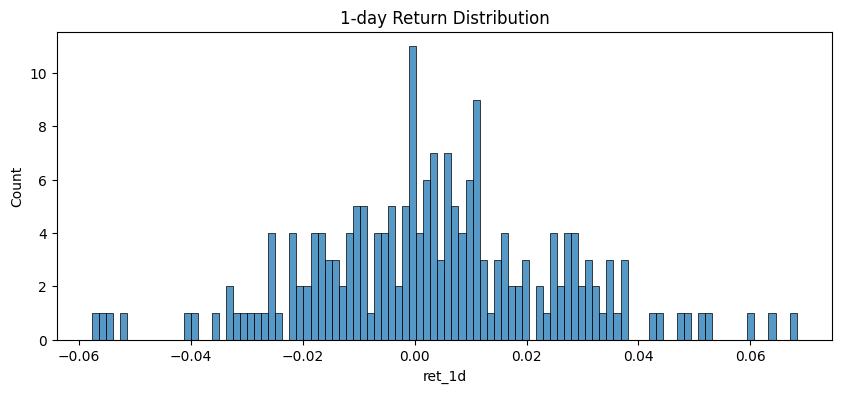

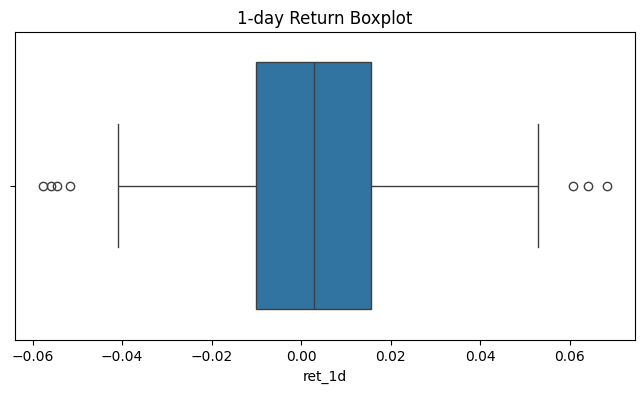

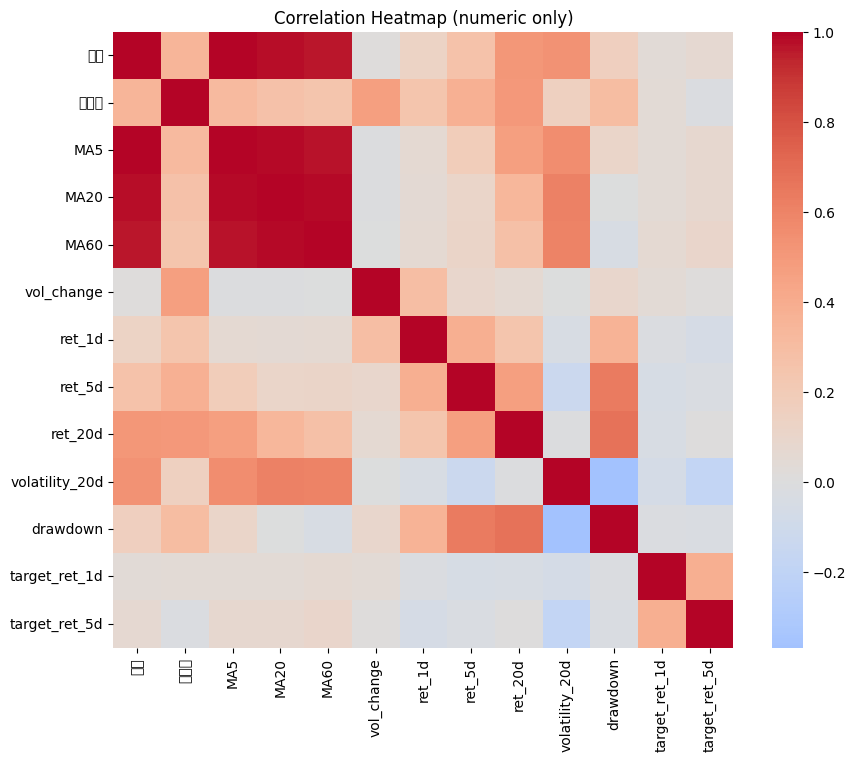

  전처리 데이터 저장: data/processed/merged_data_005930.csv
  (옵션) ML/백테스트 파이프라인 실행중...
=== 모델 성능 ===
Logistic: acc=0.6500, f1=0.7742, auc=0.8880
RandomForest: acc=0.6000, f1=0.6522, auc=0.6927
XGBoost: acc=0.6500, f1=0.6111, auc=0.7435

=== 전략 성과 ===
Rule   : total_return=0.1674, CAGR=1.6512, MDD=-0.1188
Model  : total_return=-0.0005, CAGR=-0.0032, MDD=-0.0958
BuyHold: total_return=0.1618, CAGR=1.5729, MDD=-0.1467

Top features by importance:
       feature  importance
      drawdown    0.195945
           거래량    0.134209
            종가    0.129748
    vol_change    0.114476
          MA60    0.110871
           MA5    0.108793
volatility_20d    0.108768
          MA20    0.097190
            시가    0.000000
            고가    0.000000
  모델/백테스트 완료 — 요약:
    - Logistic: acc=0.650, f1=0.774, auc=0.888
    - RandomForest: acc=0.600, f1=0.652, auc=0.693
    - XGBoost: acc=0.650, f1=0.611, auc=0.743
Loaded: data/processed/merged_data_005930.csv
=== 모델 성능 ===
Logistic: acc=0.6500, f1=0.7742, auc=0.8

In [ ]:

# ==========================================
# 0. 필요 라이브러리
# ==========================================
# Colab에는 대부분 설치되어 있으나, 없으면 주석 해제 후 설치
# !pip install openpyxl plotly

import os
import time
import requests
import json
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import glob
import datetime
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 공통 header (모든 요청에서 사용)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept": "application/json"
}

# optional XGBoost, 있으면 XGBClassifier 사용, 없으면 무시하고 tr-except 사용함.
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except:
    _HAS_XGB = False

# ==========================================
# 1. 공통 유틸 함수 / 상수
# ==========================================
def parse_krw_hangeul(value):
    """
    거래대금(억) 단위의 한글 표현을 정수(원 단위)로 변환.
    예: "1,234억원" -> 123400000000
    """
    if value is None:
        return 0

    value = str(value).replace(',', '').replace(' ', '')

    if value.endswith('억원'):
        try:
            num = float(value.replace('억원', ''))
            return int(num * 100000000)
        except ValueError:
            return 0

    try:
        return int(value)
    except ValueError:
        return 0

# 네이버 m.stock 공통 헤더 (차단 방지용)
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    ),
    "Referer": "https://m.stock.naver.com/",
    "Origin": "https://m.stock.naver.com",
    "Accept": "application/json, text/plain, */*",
}


def clean_value(value):
    """
    API 값에서 '배', '원', '억원', ',' 등을 제거해
    숫자만 남기거나 깔끔한 문자열로 정리.
    """
    if value is None or value == "":
        return "N/A"
    return (
        str(value)
        .replace('배', '')
        .replace('원', '')
        .replace('억원', '')
        .replace(',', '')
        .strip()
    )


# ==========================================
# 2. 거래량 상위 종목 / KOSPI 지수
# ==========================================
def get_top_stocks_data():
    """
    네이버 금융 API에서 거래량 상위 주식 데이터를 가져와 DataFrame으로 반환.
    """
    stocks_per_page = 20
    base_api_url = "https://m.stock.naver.com/api/stocks/quantTop/all"

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "application/json, text/plain, */*",
        "Referer": "https://m.stock.naver.com/",
    }

    total_api_pages_to_fetch = 2 # 테스트용: 2페이지(40개). 필요시 늘리면 됨.
    fetched_data = []

    print(f"=== 상위 주식 데이터 크롤링 시작 (총 {total_api_pages_to_fetch * stocks_per_page}개 목표) ===")

    for i in range(1, total_api_pages_to_fetch + 1):
        full_url = f"{base_api_url}?page={i}&pageSize={stocks_per_page}"
        print(f" -> 페이지 {i} 요청 중...")

        try:
            response = requests.get(full_url, headers=headers, timeout=5)
            response.raise_for_status()
            data = response.json()

            if isinstance(data, dict) and 'stocks' in data and isinstance(data['stocks'], list):
                fetched_data.extend(data['stocks'])
            else:
                print(f" -> 페이지 {i} 데이터 없음 혹은 형식 오류.")
                break

        except Exception as e:
            print(f" -> 페이지 {i} 오류 발생: {e}")
            break

        time.sleep(0.1) # 서버 부하 방지용 딜레이

    if not fetched_data:
        return pd.DataFrame()
    # DataFrame으로 변환 후 컬럼 정리
    df = pd.DataFrame(fetched_data)
    cols = {
        'itemCode': '종목코드',
        'stockName': '종목명',
        'closePrice': '현재가',
        'fluctuationsRatio': '등락률',
        'accumulatedTradingVolume': '거래량',
        'accumulatedTradingValueKrwHangeul': '거래대금',
    }

    available_cols = [c for c in cols.keys() if c in df.columns]
    df = df[available_cols].rename(columns=cols)

    # 거래대금 항목이 있으면 파싱
    if '거래대금' in df.columns:
        df['거래대금'] = df['거래대금'].apply(parse_krw_hangeul)

    return df


def get_kospi_info():
    """
    네이버에서 KOSPI 기본 정보 및 실시간 정보를 가져온다.
    반환값: {'basic': ..., 'realtime': ...}
    """
    basic_url = "https://m.stock.naver.com/api/index/KOSPI/basic"
    realtime_url = "https://polling.finance.naver.com/api/realtime/domestic/index/KOSPI"

    result = {}

    # 기본 정보
    try:
        res = requests.get(basic_url, timeout=5).json()
        result['basic'] = res
    except Exception as e:
        print(f"KOSPI 기본 정보 오류: {e}")
        result['basic'] = None

    # 실시간 정보
    try:
        res = requests.get(realtime_url, timeout=5).json()
        result['realtime'] = res.get('result', res)
    except Exception as e:
        print(f"KOSPI 실시간 정보 오류: {e}")
        result['realtime'] = None

    return result


def print_kospi_formatted(kospi_data):
    basic = kospi_data.get('basic')
    if not basic:
        print("KOSPI 정보를 불러오지 못했습니다.")
        return

    # 1) 기본 시세 정보
    name = basic.get('stockName', 'KOSPI')
    price = basic.get('closePrice', 'N/A')
    change = basic.get('compareToPreviousClosePrice', '0')
    ratio = basic.get('fluctuationsRatio', '0')

    # 등락 방향
    direction_info = basic.get('compareToPreviousPrice', {})
    direction_text = direction_info.get('text', '')
    symbol = " "
    if direction_text == '상승':
        symbol = "▲"
    elif direction_text == '하락':
        symbol = "▼"

    # 거래소 정보
    exchange_info = basic.get('stockExchangeType', {})
    nation = exchange_info.get('nationName', 'KR')
    ex_name = exchange_info.get('nameKor', '코스피')

    # 시간 포맷 정리
    time_str = basic.get('localTradedAt', '')
    if 'T' in time_str:
        time_str = time_str.split('+')[0].replace('T', ' ')

    # 일봉 차트 이미지 URL
    charts = basic.get('imageCharts', {})
    day_chart = charts.get('day', '정보 없음')

    # 출력
    print("┌──────────────────────────────────────────────────┐")
    print(f"│  🇰🇷  [{nation}] {ex_name} ({name}) 상세 현황      │")
    print("├──────────────────────────────────────────────────┤")
    print(f"│  현재지수  : {price:<33} │")
    print(f"│  등락률    : {symbol} {change} ({ratio}%) {direction_text:<15} │")
    print("├──────────────────────────────────────────────────┤")
    print(f"│  장 상태   : {basic.get('marketStatus')}                          │")
    print(f"│  기준시간  : {time_str:<26}  │")
    print(f"│  거래소    : {exchange_info.get('nameEng')} ({exchange_info.get('code')})              │")
    print("├──────────────────────────────────────────────────┤")
    print("│  📊 일봉 차트 (클릭하여 보기):                   │")
    print(f"│  {day_chart:<46}  │")
    print("└──────────────────────────────────────────────────┘")


# ==========================================
# 3. 종목코드 / 시세 / 재무 / 통합 정보
# ==========================================
def get_code_from_excel(stock_name, file_name='stockCodeInfo.xlsx'):
    """
    로컬 엑셀 파일에서 '회사명'으로 종목코드를 찾는다.
    - 종목코드는 0으로 시작하므로 문자열(str)로 읽어야 한다.
    """
    if not os.path.exists(file_name):
        print(f"오류: '{file_name}' 파일이 현재 폴더에 없습니다.")
        # 업로드한 파일 중 동일 이름이 있는지 시도
        if file_name in uploaded.keys():
            # Colab 업로드 시 파일은 현재 경로에 저장됨
            print(f" -> 업로드된 파일이 있으므로 계속 진행합니다.")
        else:
            return None

    try:
        df = pd.read_excel(file_name, dtype={'종목코드': str})
        found_row = df[df['회사명'] == stock_name]

        if not found_row.empty:
            return str(found_row.iloc[0]['종목코드'])

        print(f"'{stock_name}'을(를) 엑셀 파일에서 찾을 수 없습니다.")
        return None

    except Exception as e:
        print(f"엑셀 파일 읽기 오류: {e}")
        return None


def get_daily_stock_prices(code, pages=1):
    """
    종목코드(code)를 받아 일별 시세를 가져와 DataFrame으로 반환.
    호출 URL: https://m.stock.naver.com/api/stock/{code}/price
    """
    url = f"https://m.stock.naver.com/api/stock/{code}/price"

    all_prices = []

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://m.stock.naver.com/"
        }

    print(f"=== [{code}] 시세 데이터 요청 중... ===")

    for page in range(1, pages + 1):
        params = {"pageSize": 20, "page": page}

        try:
            response = requests.get(url, params=params, headers=headers, timeout=5)
            data = response.json()
            if len(data) > 0:
                all_prices.extend(data)
                print(f" -> {page}페이지 수집 성공 ({len(data)}건)")
            else:
                break

        except Exception as e:
            print(f"API 요청 오류: {e}")
            break

        time.sleep(0.1) # 차단 방지용 딜레이

    if not all_prices:
        return pd.DataFrame()

    df = pd.DataFrame(all_prices)

    # 컬럼명 한글화
    rename_map = {
        'localTradedAt': '날짜',
        'closePrice': '종가',
        'compareToPreviousClosePrice': '전일비',
        'openPrice': '시가',
        'highPrice': '고가',
        'lowPrice': '저가',
        'accumulatedTradingVolume': '거래량',
        'fluctuationsRatio': '등락률', # 있으면 함께 사용
    }

    available = [c for c in rename_map.keys() if c in df.columns]
    return df[available].rename(columns=rename_map)


def get_financial_summary(code):
    """
    연간 재무 요약 정보 가져오기.
    호출 URL: https://m.stock.naver.com/api/stock/{code}/finance/annual
    반환: 행=항목, 열=연도(YYYYMM) 인 DataFrame
    """
    url = f"https://m.stock.naver.com/api/stock/{code}/finance/annual"
    res = requests.get(url, headers=headers)

    if res.status_code != 200:
        print(" 재무제표 API 오류")
        return pd.DataFrame()

    data = res.json()
    finance = data.get("finance", None)

    #  추가해야 할 예외 처리 부분
    if finance is None:
        print("⚠ 재무제표 데이터가 제공되지 않는 종목입니다.")
        return pd.DataFrame()

    titles = finance.get("trTitleList", [])
    years = [t["key"] for t in titles]

    trList = finance.get("trList", [])
    rows = []
    for item in trList:
        label = item["title"]
        values = item["trValue"]
        row = {"지표": label}
        row.update({year: values[i] for i, year in enumerate(years)})
        rows.append(row)

    df = pd.DataFrame(rows)
    return df


def get_stock_overview(code):
    """
    통합(integration) 엔드포인트를 활용해
    재무/수급/리포트/산업비교 등 다양한 정보를 한 번에 가져온다.

    호출 URL: https://m.stock.naver.com/api/stock/{code}/integration

    반환:
        {
            "totalInfos": {...},
            "dealTrend": DataFrame,
            "researchReports": list,
            "industryCompare": DataFrame,
            "consensus": {...},
            "corporationSummary": {...}
        }
    """
    url = f"https://m.stock.naver.com/api/stock/{code}/integration"

    try:
        res = requests.get(url, headers=HEADERS, timeout=5)
        data = res.json()
    except Exception:
        return {}

    result = {}

    # ① 핵심 기업지표 (시총, PER, 52주 최고/최저 등)
    total_infos = data.get("totalInfos", [])
    total_info_dict = {}
    for item in total_infos:
        key = item.get("key")
        value = item.get("value")
        total_info_dict[key] = value
    result["totalInfos"] = total_info_dict

    # ② 최근 5일 수급
    deals = data.get("dealTrendInfos", [])
    deal_list = []
    for d in deals:
        deal_list.append({
            "bizdate": d.get("bizdate"),
            "closePrice": d.get("closePrice"),
            "compareToPreviousClosePrice": d.get("compareToPreviousClosePrice"),
            "foreigner": d.get("foreignerPureBuyQuant"),
            "institution": d.get("organPureBuyQuant"),
            "individual": d.get("individualPureBuyQuant"),
            "volume": d.get("accumulatedTradingVolume"),
        })
    result["dealTrend"] = pd.DataFrame(deal_list)

    # ③ 증권사 리포트
    result["researchReports"] = data.get("researches", [])

    # ④ 산업 내 경쟁사 비교
    industry_list = []
    industry_raw = data.get("industryCompareInfo", [])
    for info in industry_raw:
        industry_list.append({
            "종목명": info.get("stockName"),
            "종가": info.get("closePrice"),
            "등락": info.get("compareToPreviousClosePrice"),
            "등락률": info.get("fluctuationsRatio"),
            "시총": info.get("marketValue"),
        })
    result["industryCompare"] = pd.DataFrame(industry_list)

    # ⑤ 목표가 컨센서스
    result["consensus"] = data.get("consensusInfo", {})

    # ⑥ 회사 개요
    result["corporationSummary"] = data.get("corporationSummary", {})

    return result


def print_comprehensive_report(stock_name, stock_code):
    """
    한 종목에 대해:
    - 핵심 지표
    - 최근 수급
    - 증권사 리포트
    - 목표주가 컨센서스
    - 경쟁사 비교
    - 연간 재무제표
    를 콘솔에 종합 출력.
    """
    if not stock_code:
        return

    print("\n" + "=" * 60)
    print(f" 📢 [{stock_name}] ({stock_code}) 종합 분석 리포트")
    print("=" * 60 + "\n")

    overview = get_stock_overview(stock_code)
    financial = get_financial_summary(stock_code)

    # 1) 핵심지표 요약
    info = overview.get("totalInfos", {})
    important_keys = [
        ("시가총액", "시총"),
        ("52주 최고", "52주 최고"),
        ("52주 최저", "52주 최저"),
        ("PER", "PER"),
        ("EPS", "EPS"),
        ("추정PER", "추정PER"),
        ("추정EPS", "추정EPS"),
        ("PBR", "PBR"),
        ("BPS", "BPS"),
        ("배당수익률", "배당수익률"),
        ("주당배당금", "주당배당금"),
    ]

    print("[1] 핵심 지표 요약")
    print("────────────────────────────────────────")
    for label, key in important_keys:
        value = info.get(key)
        if value not in ["", None, "-"]:
            print(f"{label:<12} : {value}")
    print("────────────────────────────────────────\n")

    # 2) 최근 수급
    print("[2] 최근 5일 투자자 순매수")
    print("────────────────────────────────────────")
    deal_df = overview.get("dealTrend")
    if isinstance(deal_df, pd.DataFrame) and not deal_df.empty:
        print(deal_df)
    else:
        print("데이터 없음")
    print("────────────────────────────────────────\n")

    print("[3] 최신 증권사 리포트 (최근 5개)")
    print("────────────────────────────────────────")

    # 3) 증권사 리포트
    reports = overview.get("researchReports", [])
    if reports:
        for r in reports[:5]:
            title = r.get("tit", "")
            broker = r.get("bnm", "")
            date = r.get("wdt", "")
            print(f"- {broker} : \"{title}\" ({date})")
    else:
        print("데이터 없음")
    print("────────────────────────────────────────\n")

    # 4) 목표주가 컨센서스
    print("[4] 목표주가 컨센서스")
    print("────────────────────────────────────────")
    consensus = overview.get("consensus", {})
    if consensus:
        print(f"평균 목표가 : {consensus.get('priceTargetMean')}원")
        print(f"평균 의견   : {consensus.get('recommMean')}")
        print(f"작성일     : {consensus.get('createDate')}")
    else:
        print("데이터 없음")
    print("────────────────────────────────────────\n")

    # 5) 경쟁사 비교
    print("[5] 경쟁사 비교")
    print("────────────────────────────────────────")
    ind_df = overview.get("industryCompare")
    if isinstance(ind_df, pd.DataFrame) and not ind_df.empty:
        print(ind_df)
    else:
        print("데이터 없음")
    print("────────────────────────────────────────\n")

    # 6) 연간 재무제표
    print("[6] 연간 재무제표")
    print("────────────────────────────────────────")
    if isinstance(financial, pd.DataFrame) and not financial.empty:
        print(financial)
    else:
        print("데이터 없음")
    print("────────────────────────────────────────")

    print("\n" + "=" * 60 + "\n")


# ==========================================
# 4. 추가: 전처리/피처엔지니어링/EDA 함수 (추가된 부분)
# ==========================================
def process_time_series(df_ts, date_col='날짜', price_col='종가', volume_col='거래량', ticker=None):
    """
    단일 종목의 일별 시계열 DataFrame을 받아서:
    - 날짜 정리, 결측 처리, 이상치 처리(음수/0 제거)
    - 이동평균(MA5, MA20, MA60), 거래량 변화율, 수익률(1/5/20), 변동성(20일), Drawdown
    - 타깃(다음날 수익률, 5일 수익률) 생성
    반환: 처리된 DataFrame
    """
    df = df_ts.copy()

    # 날짜 컬럼 명확화 및 정렬
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values(by=date_col).reset_index(drop=True)
    else:
        # 만약 날짜 컬럼이 없으면 인덱스를 날짜로 간주하지 않음
        pass

    # 숫자형 변환: 쉼표 제거 후 numeric 변환 (안정성)
    for c in [price_col, volume_col]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.replace(',', '').replace('nan', np.nan)
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # 결측치 처리: 선형 보간 -> 앞 채움 -> 뒤 채움 -> 남으면 제거
    df = df.sort_values(by=date_col) if date_col in df.columns else df
    if price_col in df.columns:
        df[price_col] = df[price_col].interpolate(method='linear')
        df[price_col] = df[price_col].fillna(method='ffill').fillna(method='bfill')

    if volume_col in df.columns:
        df[volume_col] = df[volume_col].fillna(0)

    # 이상치 처리: 음수/0 가격 제거 (0인 경우는 거래정지 등 가능성 있으니 보존 여부는 사용자가 선택)
    if price_col in df.columns:
        df = df[df[price_col] > 0].copy()

    # 이동평균
    for w in [5, 20, 60]:
        if price_col in df.columns:
            df[f"MA{w}"] = df[price_col].rolling(window=w, min_periods=1).mean()

    # 거래량 변화율
    if volume_col in df.columns:
        df['vol_change'] = df[volume_col].pct_change().replace([np.inf, -np.inf], np.nan)

    # 수익률 (일간/5일/20일)
    if price_col in df.columns:
        df['ret_1d'] = df[price_col].pct_change(1)
        df['ret_5d'] = df[price_col].pct_change(5)
        df['ret_20d'] = df[price_col].pct_change(20)

    # 변동성(20일 표준편차)
    if 'ret_1d' in df.columns:
        df['volatility_20d'] = df['ret_1d'].rolling(20).std()

    # Drawdown: 현재가 / 최근 60일 최고 - 1
    if price_col in df.columns:
        roll_max = df[price_col].rolling(window=60, min_periods=1).max()
        df['drawdown'] = df[price_col] / roll_max - 1

    # 타깃 생성: 다음날 수익률, 5일 수익률
    if 'ret_1d' in df.columns:
        df['target_ret_1d'] = df['ret_1d'].shift(-1)
    if 'ret_5d' in df.columns:
        df['target_ret_5d'] = df['ret_5d'].shift(-5)

    # 종목명/티커 컬럼 삽입 (있으면 유지, 없으면 추가)
    if ticker:
        df['ticker'] = ticker
    else:
        if '종목명' not in df.columns and 'ticker' not in df.columns:
            df['ticker'] = 'UNKNOWN'

    # 최종 정렬
    if date_col in df.columns:
        df = df.sort_values(by=date_col).reset_index(drop=True)

    return df


def eda_and_visualize(df, date_col='날짜', price_col='종가', save_fig=False, prefix='eda'):
    """
    기본적인 EDA 시각화:
    - 가격 + MA (plotly)
    - 수익률 분포 (hist), 박스플롯
    - 수치형 상관관계 히트맵 (숫자형 컬럼만 사용)
    결과: None (화면 출력), 필요하면 저장 가능
    """
    # 안전: 숫자 컬럼만 골라서 상관계수 계산
    numeric_df = df.select_dtypes(include=[np.number])

    # 1) Plotly: 가격 & 이동평균
    try:
        if price_col in df.columns:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=df[date_col] if date_col in df.columns else df.index,
                                     y=df[price_col], mode='lines', name='Close'))
            for ma in ['MA5', 'MA20', 'MA60']:
                if ma in df.columns:
                    fig.add_trace(go.Scatter(
                        x=df[date_col] if date_col in df.columns else df.index,
                        y=df[ma], mode='lines', name=ma))
            fig.update_layout(title='Price & Moving Averages', xaxis_title='Date', yaxis_title='Price')
            fig.show()
    except Exception as e:
        print("Plotly 가격 그래프 생성 중 오류:", e)

    # 2) 수익률 분포, 박스플롯
    try:
        if 'ret_1d' in df.columns:
            plt.figure(figsize=(10,4))
            sns.histplot(df['ret_1d'].dropna(), bins=100, kde=False)
            plt.title('1-day Return Distribution')
            plt.show()

            plt.figure(figsize=(8,4))
            sns.boxplot(x=df['ret_1d'].dropna())
            plt.title('1-day Return Boxplot')
            plt.show()
    except Exception as e:
        print("수익률 분포/박스플롯 생성 중 오류:", e)

    # 3) 상관관계 히트맵 (숫자형만)
    try:
        if numeric_df.shape[1] > 1:
            plt.figure(figsize=(10,8))
            sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0)
            plt.title('Correlation Heatmap (numeric only)')
            plt.show()
        else:
            print("Heatmap 생략 — 숫자형 컬럼이 부족합니다.")
    except Exception as e:
        print("히트맵 생성 중 오류:", e)

def plot_extra_eda(df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # ===== 숫자형 변환 처리 (쉼표 제거 후 float 로 변환) =====
    df_numeric = df.copy()
    for col in df_numeric.columns:
        if df_numeric[col].dtype == 'object':
            df_numeric[col] = df_numeric[col].astype(str).str.replace(',', '', regex=False)
            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='ignore')

    # 히스토그램 (일간 수익률)
    if '일간수익률' in df_numeric.columns:
        plt.figure(figsize=(8, 4))
        df_numeric['일간수익률'].dropna().hist(bins=50)
        plt.title("일간 수익률 분포")
        plt.xlabel("수익률")
        plt.ylabel("빈도")
        plt.show()

    # 박스플롯 (가격 / 거래량)
    for cols in [['종가', '거래량'], ['MA5', 'MA20', 'MA60']]:
        valid_cols = [c for c in cols if c in df_numeric.columns]
        if len(valid_cols) > 0:
            plt.figure(figsize=(8, 4))
            df_numeric[valid_cols].plot.box()
            plt.title(f"{', '.join(valid_cols)} 박스플롯")
            plt.show()

    # 상관관계 히트맵
    plt.figure(figsize=(10, 8))
    corr = df_numeric.corr(numeric_only=True)
    sns.heatmap(corr, cmap='coolwarm', annot=False)
    plt.title("상관관계 Heatmap")
    plt.show()

def _safe_save_csv(df, path):
    "기존 파일 있으면 백업 후 저장"
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    if os.path.exists(path):
        bak = path + ".bak." + datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        os.replace(path, bak)
    df.to_csv(path, index=False)

def _load_latest_processed(path="data/processed", pattern="merged_data_*.csv"):
    "data/processed의 최신 processed CSV 읽기"
    files = sorted(glob.glob(os.path.join(path, pattern)))
    if not files:
        raise FileNotFoundError("processed CSV가 없습니다. 먼저 crawling2 전처리 파이프라인을 실행하세요.")
    latest = files[-1]
    print("Loaded:", latest)
    return pd.read_csv(latest), latest

# ==========================================
# 5. 기본 체크/백테스트 (crawling3 에서 추가됨)
# ==========================================
def _ensure_basic(df):
    "필수 컬럼 존재 검사 및 한글→영문 매핑"
    rename_map = {
        '일간수익률':'ret_1d','주간수익률':'ret_5d','월간수익률':'ret_20d',
        '변동성_20':'volatility_20d','고점대비하락률':'drawdown','거래량변화율':'vol_change'
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
    if '종가' not in df.columns or 'ret_1d' not in df.columns:
        raise KeyError("필수 컬럼(종가, ret_1d)이 필요합니다.")
    return df

def _backtest(df, signal_col='signal', price_col='종가', initial_capital=1_000_000, fee=0.0005, slippage=0.0002):
    "단순 시장가 진입/전량 청산 백테스트"
    df = df.reset_index(drop=True)
    cash = initial_capital
    shares = 0.0
    nav = []
    for i in range(len(df) - 1):
        nav.append(cash + shares * df.loc[i, price_col])
        sig = int(df.loc[i, signal_col])
        nxt = df.loc[i+1, price_col]
        if sig == 1 and cash > 0:
            amt = cash
            shares += amt * (1 - fee - slippage) / nxt
            cash = 0
        elif sig == 0 and shares > 0:
            cash += shares * nxt * (1 - fee - slippage)
            shares = 0
    nav.append(cash + shares * df.loc[len(df)-1, price_col])
    return pd.Series(nav)

def _perf_from_nav(nav, initial_capital=1_000_000):
    "NAV 시계열에서 총수익, CAGR, MDD 계산"
    total = float(nav.iloc[-1] / initial_capital - 1)
    days = len(nav)
    years = days / 252 if days>0 else 0
    cagr = (nav.iloc[-1] / initial_capital) ** (1/years) - 1 if years>0 else float('nan')
    mdd = float(((nav - nav.cummax()) / nav.cummax()).min())
    return {'total_return': total, 'CAGR': cagr, 'MDD': mdd}

# ==========================================
# 6. 모델링/평가/신호생성 (ret_* 자동 제외), (crawling3 에서 추가됨)
# ==========================================
def _simulate_trades(df, signal_col='signal', price_col='종가', initial_capital=1_000_000, fee=0.0005, slippage=0.0002):
    """신호로부터 거래 로그(다음일 체결 가정)와 NAV 시계열을 생성."""
    df = df.reset_index(drop=True).copy()
    cash = initial_capital
    shares = 0.0
    in_position = False
    nav = []
    trades = []
    for i in range(len(df)-1):
        nav.append(cash + shares * float(df.loc[i, price_col]))
        sig = int(df.loc[i, signal_col])
        exec_price = float(df.loc[i+1, price_col])  # 다음일 종가로 체결 가정
        exec_date = df.loc[i+1, '날짜'] if '날짜' in df.columns else i+1
        if sig == 1 and not in_position and cash > 0:
            buy_cash = cash
            shares_bought = (buy_cash * (1 - fee - slippage)) / exec_price
            shares += shares_bought
            cash -= buy_cash
            in_position = True
            trades.append({'date': exec_date, 'action': 'BUY', 'price': exec_price, 'shares': shares_bought, 'cash': cash})
        elif sig == 0 and in_position and shares > 0:
            proceeds = shares * exec_price * (1 - fee - slippage)
            cash += proceeds
            trades.append({'date': exec_date, 'action': 'SELL', 'price': exec_price, 'shares': shares, 'cash': cash})
            shares = 0.0
            in_position = False
    # 마지막일 NAV
    nav.append(cash + shares * float(df.loc[len(df)-1, price_col]))
    nav_series = pd.Series(nav, index=df.index[:len(nav)])
    trades_df = pd.DataFrame(trades)
    return trades_df, nav_series

def _compute_perf_from_nav_series(nav_series, initial=1_000_000):
    total = float(nav_series.iloc[-1] / initial - 1)
    days = len(nav_series)
    years = days / 252 if days > 0 else 0
    cagr = (nav_series.iloc[-1] / initial) ** (1/years) - 1 if years > 0 else float('nan')
    mdd = float(((nav_series - nav_series.cummax()) / nav_series.cummax()).min())
    return {'total_return': total, 'CAGR': cagr, 'MDD': mdd}

def run_c3_pipeline_allmodels(df=None, features=None, model_threshold=0.55, initial_capital=1_000_000, fast=False):
    """
    확장형 파이프라인:
    - Logistic, RandomForest, (XGBoost 있으면) 모두 학습/평가
    - 각 모델의 시그널로 백테스트 수행, 트레이드 로그 저장
    - RF/XGB의 경우 feature importance TOP3만 출력
    - 결과 파일 저장 (output/, models/)
    """
    # 1) df 로드/기본검사
    if df is None:
        df, path = _load_latest_processed()
    df = _ensure_basic(df)

    # 2) feature 선정 (ret_* 계열 자동 제외 -> 데이터 누수 방지)
    base_features = ['종가','시가','고가','저가','거래량','MA5','MA20','MA60',
                     'volatility_20d','drawdown','vol_change']
    forbidden = {'ret_1d','ret_5d','ret_20d','target_ret_1d','target_ret_5d'}
    feat_list = [c for c in base_features if c in df.columns and c not in forbidden]
    if features:
        feat_list = [c for c in features if c in df.columns and c not in forbidden]
    if not feat_list:
        raise ValueError("사용 가능한 feature가 없습니다. 전처리 결과를 확인하세요.")

    # numeric 강제 & target
    df[feat_list] = df[feat_list].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['종가','ret_1d']).copy()
    df[feat_list] = df[feat_list].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df['target'] = (df['ret_1d'] > 0).astype(int)

    # train/test split (시간순)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test  = df.iloc[split_idx:].reset_index(drop=True)

    X_train, y_train = train[feat_list], train['target']
    X_test,  y_test  = test[feat_list],  test['target']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # 모델 목록 (fast 옵션으로 경량화)
    rf_n  = 50 if fast else 200
    xgb_n = 50 if fast else 200
    models = {
        'Logistic': LogisticRegression(max_iter=400),
        'RandomForest': RandomForestClassifier(n_estimators=rf_n, random_state=42)
    }
    if _HAS_XGB:
        models['XGBoost'] = XGBClassifier(n_estimators=xgb_n, random_state=42, use_label_encoder=False, eval_metric='logloss')

    # 학습/평가 (간결 요약만 수집)
    perf = {}
    trained = {}
    for name, m in models.items():
        m.fit(X_train_s, y_train)
        pred = m.predict(X_test_s)
        try:
            proba = m.predict_proba(X_test_s)[:,1]
        except Exception:
            # 모델에 predict_proba가 없을 수 있음
            proba = np.zeros(len(pred))
        # 안전하게 AUC 계산
        try:
            auc_v = float(roc_auc_score(y_test, proba))
        except Exception:
            auc_v = float('nan')
        perf[name] = {
            'accuracy': float(accuracy_score(y_test, pred)),
            'f1': float(f1_score(y_test, pred)),
            'auc': auc_v
        }
        trained[name] = m

    # signals: RF 우선, rule (MA5>MA20), bh
    rf = trained.get('RandomForest', None)
    if rf is not None:
        test['proba'] = rf.predict_proba(X_test_s)[:,1]
        test['model_signal'] = (test['proba'] > model_threshold).astype(int)
    else:
        test['proba'] = 0.0
        test['model_signal'] = 0

    test['rule_signal'] = ((test['MA5'] > test['MA20']).astype(int)) if ('MA5' in test.columns and 'MA20' in test.columns) else 0

    # 백테스트 NAV (기존 단순 전략)
    nav_rule  = _backtest(test, signal_col='rule_signal', price_col='종가', initial_capital=initial_capital)
    nav_model = _backtest(test, signal_col='model_signal', price_col='종가', initial_capital=initial_capital)
    nav_bh    = (test['종가'] / test['종가'].iloc[0]) * initial_capital

    perf_rule  = _perf_from_nav(nav_rule, initial_capital)
    perf_model = _perf_from_nav(nav_model, initial_capital)
    perf_bh    = _perf_from_nav(nav_bh.reset_index(drop=True), initial_capital)

    # feature importance (RF / XGB 우선)
    feat_imp = None
    if 'RandomForest' in trained:
        try:
            rf_imp = trained['RandomForest'].feature_importances_
            feat_imp = pd.DataFrame({'feature': feat_list, 'importance': rf_imp}).sort_values('importance', ascending=False).reset_index(drop=True)
        except Exception:
            feat_imp = None
    elif 'XGBoost' in trained:
        try:
            x_imp = trained['XGBoost'].feature_importances_
            feat_imp = pd.DataFrame({'feature': feat_list, 'importance': x_imp}).sort_values('importance', ascending=False).reset_index(drop=True)
        except Exception:
            feat_imp = None

    # ====== 새로 추가: Top3 표 출력 및 파일 저장 ======
    if feat_imp is not None and not feat_imp.empty:
        top3 = feat_imp.head(3).copy().reset_index(drop=True)
        print("\n=== Feature Importance (Top 3) ===")
        print(top3.to_string(index=False))
        # 저장
        os.makedirs('output', exist_ok=True)
        top3.to_csv('output/feature_importance_top3.csv', index=False)
    else:
        print("\n(Feature importance not available)")

    # ====== 새로 추가: 거래(매수/매도) 기록 생성 (model_signal 기준) ======
    trades = []
    cash = initial_capital
    shares = 0.0
    holding = False
    buy_price = None
    buy_idx = None
    fee = 0.0005
    slippage = 0.0002

    # 우리가 _backtest과 동일한 '다음날 가격' 실행을 기준으로 단순한 거래표 생성
    for i in range(len(test)-1):
        sig = int(test.loc[i, 'model_signal'])
        next_price = float(test.loc[i+1, '종가'])
        date = test.loc[i, '날짜'] if '날짜' in test.columns else i
        next_date = test.loc[i+1, '날짜'] if '날짜' in test.columns else i+1

        if sig == 1 and not holding and cash > 0:
            # buy at next day's price using all cash
            shares = (cash * (1 - fee - slippage)) / next_price
            buy_price = next_price
            buy_idx = i+1
            buy_date = next_date
            holding = True
            cash = 0.0
            trades.append({
                'action':'buy', 'date': str(buy_date), 'price': buy_price, 'shares': shares, 'cash_after': cash
            })
        elif sig == 0 and holding and shares > 0:
            # sell all at next day's price
            sell_price = next_price
            cash = shares * sell_price * (1 - fee - slippage)
            sell_date = next_date
            pnl = cash - initial_capital if len(trades)>0 else cash - 0
            trades.append({
                'action':'sell', 'date': str(sell_date), 'price': sell_price, 'shares': shares, 'cash_after': cash
            })
            # reset
            shares = 0.0
            holding = False
            buy_price = None
            buy_idx = None

    # If still holding at the end, we record a final sell at last price
    if holding and shares > 0:
        final_price = float(test.loc[len(test)-1, '종가'])
        final_date = test.loc[len(test)-1, '날짜'] if '날짜' in test.columns else len(test)-1
        cash = shares * final_price * (1 - fee - slippage)
        trades.append({
            'action':'sell', 'date': str(final_date), 'price': final_price, 'shares': shares, 'cash_after': cash
        })
        holding = False
        shares = 0.0

    trades_df = pd.DataFrame(trades)

    # 거래 표 저장 (있다면)
    if not trades_df.empty:
        trades_df.to_csv('output/trades.csv', index=False)
        print("\nSaved trades -> output/trades.csv")
        # 간단 출력: (상위 몇개)
        print("\n=== Trades (sample) ===")
        print(trades_df.head(10).to_string(index=False))
    else:
        print("\n(No trades generated in test period)")

    # 저장: signals csv + summary json (종전 방식 유지)
    _safe_save_csv(test, 'output/strategy_signals.csv')
    summary = {
        'models': perf,
        'rule_perf': perf_rule,
        'model_perf': perf_model,
        'bh_perf': perf_bh
    }
    with open('output/c3_summary.json','w',encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    # 간결 출력(요약만)
    print("\n=== 모델 성능 ===")
    for k,v in perf.items():
        print(f"{k}: acc={v['accuracy']:.4f}, f1={v['f1']:.4f}, auc={v['auc']:.4f}")
    print("\n=== 전략 성과 ===")
    print(f"Rule   : total_return={perf_rule['total_return']:.4f}, CAGR={perf_rule['CAGR']:.4f}, MDD={perf_rule['MDD']:.4f}")
    print(f"Model  : total_return={perf_model['total_return']:.4f}, CAGR={perf_model['CAGR']:.4f}, MDD={perf_model['MDD']:.4f}")
    print(f"BuyHold: total_return={perf_bh['total_return']:.4f}, CAGR={perf_bh['CAGR']:.4f}, MDD={perf_bh['MDD']:.4f}")

    if feat_imp is not None:
        # 기존 전체 중요도 출력은 선택사항으로 남김 (주석)
        # print("\nTop features by importance (full):")
        # print(feat_imp.to_string(index=False))
        pass

    return {
        'trained': trained,
        'perf': perf,
        'summary': summary,
        'signals': test,
        'nav_rule': nav_rule,
        'nav_model': nav_model,
        'nav_bh': nav_bh,
        'feat_imp': feat_imp,
        'trades_df': trades_df
    }


# 편의 호출 (crawling3 에서 추가됨)
def run_latest(fast=False, initial_capital=1_000_000):
    df, _ = _load_latest_processed()
    return run_c3_pipeline(df=df, fast=fast, initial_capital=initial_capital)

def analyze_stock_and_run_all(stock_name, pages=10, run_c3=True, fast=False, model_threshold=0.55):
    """
    종목명 또는 종목코드를 받아서:
    1) 시세 수집 -> 전처리 -> 저장
    2) (옵션) 모델링/백테스트 실행 (run_c3=True)
    """
    # resolve code
    code = get_code_from_excel(stock_name)
    if code is None:
        if re.match(r'^\d{6}$', str(stock_name)):
            code = str(stock_name)
        else:
            raise ValueError("종목코드/회사명을 찾을 수 없습니다: " + str(stock_name))
    print(f"Analyzing {stock_name} (code={code}) ...")
    # fetch price
    df_price = get_daily_stock_prices(code, pages=pages)
    if df_price.empty:
        raise RuntimeError("시세 데이터 없음")
    # preprocess
    processed = process_time_series(df_price, date_col='날짜', price_col='종가', volume_col='거래량', ticker=stock_name)
    processed = processed.sort_values('날짜').reset_index(drop=True)
    processed['종가'] = processed['종가'].interpolate().ffill().bfill()
    processed['거래량'] = processed['거래량'].fillna(0)
    # save processed csv
    out_dir = "data/processed"; os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"merged_data_{code}.csv")
    processed.to_csv(out_path, index=False)
    print("Processed saved:", out_path)
    # EDA optional
    try:
        eda_and_visualize(processed, date_col='날짜', price_col='종가')
    except:
        pass
    # run models/backtests
    if run_c3:
        res = run_c3_pipeline_allmodels(df=processed, features=None, model_threshold=model_threshold, initial_capital=1_000_000, fast=fast)
        return res
    else:
        return {'processed': processed}

'''
# ==========================================
# 5. 실행 예시 및 통합 파이프라인 (기존 main 유지 + 추가 처리)
# ==========================================
if __name__ == "__main__":
    # 1) 거래량 상위 종목 목록
    print("\n[1] 거래량 상위 주식 목록")
    df_top = get_top_stocks_data()
    if not df_top.empty:
        # 주요 컬럼만 보기
        display_cols = [c for c in ['종목명', '현재가', '등락률', '거래량'] if c in df_top.columns]
        print(df_top[display_cols].head(5))
    else:
        print("데이터를 가져오지 못했습니다.")

    # 2) KOSPI 정보
    print("\n[2] KOSPI 정보")
    kospi_data = get_kospi_info()
    print_kospi_formatted(kospi_data)

    # 3) 특정 종목 시세 + 종합 리포트
    target_name = "삼성전자"
    stock_code = get_code_from_excel(target_name)

    if stock_code:
        print(f"\n[3] '{target_name}' 시세 조회 (코드: {stock_code})")
        df_result = get_daily_stock_prices(stock_code, pages=5)  # 필요하면 페이지 늘리기

        if not df_result.empty:
            print("\n[최신 데이터 5건]")
            if '등락률' in df_result.columns:
                display(df_result[['날짜', '종가', '전일비', '등락률', '거래량']].head(5))
            else:
                display(df_result.head(5))

            # 종합 리포트 출력
            print_comprehensive_report(target_name, stock_code)

            # =========================
            # 추가: 전처리 + EDA 파이프라인
            # =========================
            print("\n[4] 전처리 · 피처엔지니어링 · EDA 수행 중...")

            # 1) 시계열 처리
            processed = process_time_series(df_result, date_col='날짜', price_col='종가', volume_col='거래량', ticker=target_name)

            # 2) 기본 EDA 및 시각화
            eda_and_visualize(processed, date_col='날짜', price_col='종가')

            # 3) 최종 저장 (폴더 생성 및 CSV 저장)
            out_dir = "data/processed"
            os.makedirs(out_dir, exist_ok=True)
            out_path = os.path.join(out_dir, f"merged_data_{stock_code}.csv")
            processed.to_csv(out_path, index=False)
            print(f"✅ 전처리 데이터 저장 완료: {out_path}")

            # 4) 간단한 EDA 요약 자동 출력 (예시 — 필요시 확장)
            print("\n[5] 간단한 EDA 요약")
            # 예: 변동성(평균), 최근 20일 수익률 평균, 최대 낙폭
            mean_vol = processed['volatility_20d'].mean() if 'volatility_20d' in processed.columns else np.nan
            recent_ret_20d = processed['ret_20d'].tail(20).mean() if 'ret_20d' in processed.columns else np.nan
            max_dd = processed['drawdown'].min() if 'drawdown' in processed.columns else np.nan

            print(f"- 평균 20일 변동성: {mean_vol:.6f}")
            print(f"- 최근 20일 평균 20일 수익률(평균): {recent_ret_20d:.6f}")
            print(f"- 최대 낙폭 (drawdown, 음수값): {max_dd:.6f}")

        else:
            print("시세 데이터를 가져오지 못했습니다.")
    else:
        print("\n[3] 종목 코드를 확보하지 못해 전처리 파이프라인은 실행되지 않습니다.")

if stock_code:

    df_result = get_daily_stock_prices(stock_code)

    if not df_result.empty:
        # 종합 리포트 출력
        print("\n[ 종합 리포트]")
        print_comprehensive_report(target_name, stock_code)

        # ===== 시계열 처리 & EDA 분석 =====
        print("\n[ 시계열 데이터 전처리/FE 시작]")
        df_processed = process_time_series(
            df_result,
            date_col='날짜',
            price_col='종가',
            volume_col='거래량',
            ticker=target_name
        )
        print("처리 완료 — 데이터 미리보기:")
        display(df_processed.tail())

        print("\n[ EDA 시각화 실행]")
        eda_and_visualize(df_processed, date_col='날짜', price_col='종가')
        print(" EDA 완료")

    else:
        # 이 else는 'if not df_result.empty'에 대응
        print("일별 시세 데이터가 없습니다.")

else:
    # 이 else는 'if stock_code'에 대응
    print("종목코드를 찾지 못했습니다.")


print("\n[ 시계열 데이터 전처리/FE 시작]")
df_processed = process_time_series(
    df_result,
    date_col='날짜',
    price_col='종가',
    volume_col='거래량',
    ticker=target_name
)

# 결측치 처리
df_processed = df_processed.sort_values('날짜')
df_processed['종가'] = df_processed['종가'].interpolate().ffill()
df_processed['거래량'] = df_processed['거래량'].fillna(0)

# 이상치 처리
df_processed = df_processed[df_processed['종가'] > 0]
df_processed = df_processed[df_processed['거래량'] >= 0]

# 피처 엔지니어링 추가
df_processed['MA5'] = df_processed['종가'].rolling(5).mean()
df_processed['MA20'] = df_processed['종가'].rolling(20).mean()
df_processed['MA60'] = df_processed['종가'].rolling(60).mean()

df_processed['일간수익률'] = df_processed['종가'].pct_change()
df_processed['주간수익률'] = df_processed['종가'].pct_change(5)
df_processed['월간수익률'] = df_processed['종가'].pct_change(20)

df_processed['변동성_20'] = df_processed['일간수익률'].rolling(20).std()
df_processed['고점대비하락률'] = 1 - (df_processed['종가'] / df_processed['종가'].cummax())

df_processed['거래량변화율'] = df_processed['거래량'].pct_change()

print("처리 완료 — 데이터 미리보기:")
display(df_processed.tail())

# CSV 저장
df_processed.to_csv("data/processed/merged_data.csv", index=False)
print(" 저장 완료 → data/processed/merged_data.csv")

# 확장된 EDA 실행
print("\n[ EDA 시각화 실행]")
eda_and_visualize(df_processed, date_col='날짜', price_col='종가')
plot_extra_eda(df_processed)   # 새로운 시각화 함수 추가
print(" EDA 완료")

# 거래량 상위 1위 종목
if __name__ == "__main__":
    top_df = get_top_stocks_data()
    first_stock = top_df.iloc[0]
    stock_name = first_stock['종목명']
    stock_code = first_stock['종목코드']

    print(f"\n 오늘 거래량 1위 종목 자동 선정: {stock_name} ({stock_code})")

    print_comprehensive_report(stock_name, stock_code)

    df_price = get_daily_stock_prices(stock_code, pages=10)
    df_processed = process_time_series(df_price, ticker=stock_name)
    eda_and_visualize(df_processed)

# ==========================================
# 6. 실행 파이프라인
# ==========================================
stock = input("조회할 종목명을 입력하세요: ")

code = get_code_from_excel(stock)   # 엑셀에서 종목코드 찾기
if not code:
    raise ValueError(" 종목코드를 찾을 수 없습니다.")

# (1) 일별 시세 가져오기
ts = get_daily_stock_prices(code, pages=10)   # pages = 10 → 최근 200일
if ts.empty:
    raise ValueError(" 시세 데이터를 불러오지 못했습니다.")

# (2) 전처리 + 피처 엔지니어링
ts_processed = process_time_series(ts, ticker=stock)

# (3) 기본 EDA 시각화
eda_and_visualize(ts_processed)

# (4) 종합 리포트 출력 (재무/수급/리포트/경쟁사 등)
print_comprehensive_report(stock, code)

print("\n 완료되었습니다.")

'''


# ==========================================
# 7. 실행 파이프라인 (crawlimg3 에서 추가됨)
# (기존의 main은 이 파트 바로 위에 전체 주석처리 해두었습니다.
# 전 버전의 main이 필요하다면 삭제하셔도 좋습니다.)
# ==========================================

def main():
    # 1) 거래량 상위 종목 목록 (간단 출력)
    print("\n1) 거래량 상위 주식 목록")
    try:
        df_top = get_top_stocks_data()
        if not df_top.empty:
            display_cols = [c for c in ['종목명', '현재가', '등락률', '거래량'] if c in df_top.columns]
            print(df_top[display_cols].head(5))
        else:
            print("  거래량 상위 데이터를 가져오지 못했습니다.")
    except Exception as e:
        print("  거래량 상위 조회 오류:", e)

    # 2) KOSPI 정보 (간단 포맷 출력)
    print("\n2) KOSPI 정보")
    try:
        kospi_data = get_kospi_info()
        print_kospi_formatted(kospi_data)
    except Exception as e:
        print("  KOSPI 조회 오류:", e)

    # ========== 3) 대상 종목 설정 및 전체 파이프라인 실행 ==========
    # 스위치: Crawling3(모델/백테스트) 실행 여부
    RUN_CRAWLING3 = True

    # 우선 환경변수로 지정된 대상 확인
    env_target = os.environ.get("TARGET_STOCK", "").strip()
    if env_target:
        target_name = env_target
        print(f"\n3) 대상 종목 (환경변수 TARGET_STOCK 사용): {target_name}")
    else:
        # 사용자 입력 (AUTO 가능)
        while True:
            user_in = input("\n3) 분석할 종목명(예: 삼성전자), 또는 AUTO(거래량 1위) 입력: ").strip()
            if user_in == "":
                print("  종목명을 비워둘 수 없습니다. 다시 입력하세요.")
                continue
            if user_in.upper() == "AUTO":
                try:
                    top_df = get_top_stocks_data()
                    if top_df.empty:
                        print("  거래량 상위 목록을 불러오지 못했습니다. 직접 종목명을 입력하세요.")
                        continue
                    first = top_df.iloc[0]
                    target_name = first.get('종목명') or first.get('stockName') or None
                    if not target_name:
                        print("  자동선택 실패. 직접 종목명을 입력해주세요.")
                        continue
                    print(f"  AUTO 선택: 거래량 1위 종목 -> {target_name}")
                    break
                except Exception as e:
                    print("  AUTO 선택 중 오류:", e)
                    continue
            else:
                target_name = user_in
                break

    # 종목코드 검증(있으면 OK, 없으면 경고 — 이후 파이프라인에서 처리)
    stock_code = get_code_from_excel(target_name)
    if not stock_code and not re.match(r'^\d{6}$', str(target_name).strip()):
        print(f"  주의: '{target_name}'에 대한 종목코드가 엑셀에서 발견되지 않았습니다. 계속 진행하면 입력값을 종목코드로 간주하거나 내부에서 처리합니다.")

    # 실행: 수집 → 전처리 → 저장(merged) → 모델/백테스트 (RUN_CRAWLING3 스위치로 제어)
    try:
        print(f"\n3-> 실행: 대상='{target_name}'  (데이터 수집 및 전처리 시작)")
        # (1) 종목코드가 바로 숫자 6자리이면 코드로 사용
        if re.match(r'^\d{6}$', str(target_name).strip()):
            code_for_fetch = str(target_name).strip()
        else:
            code_for_fetch = stock_code

        # (2) 시세 수집
        if code_for_fetch:
            df_price = get_daily_stock_prices(code_for_fetch, pages=10)
        else:
            # try treating input as company name: attempt to lookup code inside analyze routine by passing name
            df_price = get_daily_stock_prices(get_code_from_excel(target_name) or target_name, pages=10)

        if df_price is None or df_price.empty:
            print("  시세 데이터가 없습니다. 수집 실패.")
            return

        # (3) 전처리
        processed = process_time_series(df_price, date_col='날짜', price_col='종가', volume_col='거래량', ticker=target_name)
        processed = processed.sort_values('날짜').reset_index(drop=True)
        if '종가' in processed.columns:
            processed['종가'] = processed['종가'].interpolate().ffill().bfill()
        if '거래량' in processed.columns:
            processed['거래량'] = processed['거래량'].fillna(0)

        # (4) 간단 EDA (선택적)
        try:
            eda_and_visualize(processed, date_col='날짜', price_col='종가')
        except Exception:
            pass

        # (5) 저장 (data/processed/merged_data_{code}.csv)
        out_dir = "data/processed"
        os.makedirs(out_dir, exist_ok=True)
        out_name_code = code_for_fetch if code_for_fetch else re.sub(r'\W+', '_', target_name)
        out_path = os.path.join(out_dir, f"merged_data_{out_name_code}.csv")
        processed.to_csv(out_path, index=False)
        print(f"  전처리 데이터 저장: {out_path}")

        # (6) 모델/백테스트 실행 (옵션)
        if RUN_CRAWLING3:
            print("  (옵션) ML/백테스트 파이프라인 실행중...")
            try:
                # run_c3_pipeline이 df 인풋을 받을 수 있으므로 직접 전달 (더 명확)
                res = run_c3_pipeline(df=processed, features=None, model_threshold=0.55, initial_capital=1_000_000, fast=False)
                print("  모델/백테스트 완료 — 요약:")
                # 간결 요약 출력
                if isinstance(res, dict):
                    perf = res.get('perf') or res.get('summary') or {}
                    # print model metrics if present
                    if perf and isinstance(perf, dict):
                        for m, stats in perf.items():
                            if isinstance(stats, dict) and 'accuracy' in stats:
                                print(f"    - {m}: acc={stats['accuracy']:.3f}, f1={stats.get('f1', float('nan')):.3f}, auc={stats.get('auc', float('nan')):.3f}")
                # 추가로 run_latest(최신 파일 기반 후처리) 호출 — 선택 사항
                try:
                    run_latest(fast=False)
                except Exception:
                    pass
            except Exception as e:
                print("  ML/백테스트 실행 중 오류:", e)

    except Exception as e:
        print("  전체 파이프라인 오류:", e)
        return

    print("\n프로세스 완료.")

if __name__ == "__main__":
    main()

